# Анализ аниме на MyAnimeList


## Описание

Этот проект направлен на анализ аниме с сайта MyAnimeList с целью выявления зависимостей между рейтингом аниме и такими факторами, как жанр, год выпуска и студия-производитель. Я собрала данные о топ-100 аниме по рейтингу, а также 20 случайных аниме с низким рейтингом для сравнения.

Проект реализуется с использованием языка программирования Python. Данные для анализа берутся с сайта MyAnimeList (https://myanimelist.net/) через открытое API Jikan.

Каждое аниме включает информацию о названии, оценке, жанрах, студии-производителе и годе выпуска. Собранные данные сохраняются в формате JSON.


In [48]:
import requests
import json
import time
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt

## Загрузка данных

Парсинг данных будет представлен в файле parsing.py, однако продублирую код получения топ-100 аниме по рейтингу, а также 20 случайных аниме с низким рейтингом. Для парсинга данных используется неофициальное Jikan API, которое предоставляет доступ к информации с MyAnimeList. На выходе получим JSON-файл с готовыми данными об аниме
<br>
<br>
Рассмотрим каждую функцию:
<br>
1. get_top_100_anime(limit=100). Она получает топ-аниме с наивысшими рейтингами. Делает запросы к Jikan API постранично (по 25 штук на странице), собирает название, оценку, жанры, студию и год, а потом возвращает список из 100 аниме.
2. get_low_rated_anime(page=200, limit=20). Извлекает 20 аниме с низкими оценками с конкретной страницы. Тут было проведен эксперимент для поиска страницы с аниме с р=низким рейтингом. В итоге остановилась на 200 странице, где аниме уже были с рейтингом около 5. Внитри функции лежит отправление запроса к 200-й странице рейтинга, берутся первые 20 аниме с этой страницы и возвращается отформатированный список.
3. save_to_json(data, filename="anime_data.json"). Она сохраняет собранные данные в JSON-файл. Открываем файл в режиме записи, сохраняем список словарей в формате UTF-8 с отступами. Прогоняем для первой и второй функции

In [30]:
def get_top_100_anime(limit=100):
    anime_list = []
    per_page = 25
    pages = limit // per_page
    for page in range(1, pages + 1):
        url = f"https://api.jikan.moe/v4/top/anime?page={page}"
        response = requests.get(url)
        data = response.json()
        time.sleep(1)
        for item in data.get('data', []):
            anime = {
                'title': item['title'],
                'score': item['score'],
                'genres': [genre['name'] for genre in item['genres']],
                'year': item['year'],
                'studio': item['producers'][0]['name'] if item['producers'] else None,
                'type': 'top'
            }
            anime_list.append(anime)
    return anime_list

In [101]:
def get_low_rated_anime(page=200, limit=20):
    url = f"https://api.jikan.moe/v4/top/anime?page={page}&type=tv"
    response = requests.get(url)
    data = response.json()
    time.sleep(1)
    low_rated = []
    for item in data.get('data', [])[:limit]:
        anime = {
            'title': item['title'],
            'score': item['score'],
            'genres': [genre['name'] for genre in item['genres']],
            'year': item['year'],
            'studio': item['producers'][0]['name'] if item['producers'] else None,
            'type': 'low'
        }
        low_rated.append(anime)
    return low_rated

In [32]:
def save_to_json(data, filename="anime_data.json"):
    with open(filename, "w", encoding="utf-8") as f:
        json.dump(data, f, ensure_ascii=False, indent=4)

In [103]:
top_anime = get_top_100_anime()
low_rated_anime = get_low_rated_anime()
all_anime = top_anime + low_rated_anime
save_to_json(all_anime)

## Очистка данных и подготовка к анализу

После проведения парсинга данных и получения готового json-файла сохраним их в датасет. Так будет удобнее работать в дальнейшем

In [65]:
df = pd.read_json("anime_data.json", encoding="utf-8")
df.head()

,title,score,genres,year,studio,type
0,Sousou no Frieren,9.30,"[Adventure, Drama, Fantasy]",2023.0,Aniplex,top
1,Fullmetal Alchemist: Brotherhood,9.10,"[Action, Adventure, Drama, Fantasy]",2009.0,Aniplex,top
2,Steins;Gate,9.07,"[Drama, Sci-Fi, Suspense]",2011.0,Frontier Works,top
3,Shingeki no Kyojin Season 3 Part 2,9.05,"[Action, Drama, Suspense]",2019.0,Production I.G,top
4,Gintama°,9.05,"[Action, Comedy, Sci-Fi]",2015.0,TV Tokyo,top


In [66]:
print(f"Количество записей про аниме: {len(df)}")

Количество записей про аниме: 120


Посомтрим на типы данных, которые представлены в датасете

In [67]:
df.dtypes

,0
title,object
score,float64
genres,object
year,float64
studio,object
type,object


Сразу в глаза бросается момент, связанный с жанрами аниме. Они записаны в датафрейм в виде списка. Преобразуем их в единую строку

In [68]:
df['genres'] = df['genres'].apply(lambda x: ', '.join(x) if isinstance(x, list) else x)
df.head()

,title,score,genres,year,studio,type
0,Sousou no Frieren,9.30,"Adventure, Drama, Fantasy",2023.0,Aniplex,top
1,Fullmetal Alchemist: Brotherhood,9.10,"Action, Adventure, Drama, Fantasy",2009.0,Aniplex,top
2,Steins;Gate,9.07,"Drama, Sci-Fi, Suspense",2011.0,Frontier Works,top
3,Shingeki no Kyojin Season 3 Part 2,9.05,"Action, Drama, Suspense",2019.0,Production I.G,top
4,Gintama°,9.05,"Action, Comedy, Sci-Fi",2015.0,TV Tokyo,top


Теперь удалим дублирующиеся значения

In [69]:
df = df.drop_duplicates()

In [70]:
print(f"Количество записей про аниме после удаления дубликатов: {len(df)}")

Количество записей про аниме после удаления дубликатов: 119


Видимо, были дубликаты :)
Одная запись была удалена из датафрейма

Следующий шаг - анализ значений в столбцах "год" и "студия". Там могут быть пустые значения, заполним их. В конце посмотрим на результат

In [76]:
df['studio'] = df['studio'].fillna('Unknown')
df = df[df['year'].notna()]

In [72]:
print(f"Количество записей после удаления 'year': {len(df)}")

Количество записей после удаления 'year': 90


Вновь заметим, что были записи с пргопущенными годами. Они бы помешали нашему анализу, поэтому их потеря несет лишь положительный характер

Посмотрим на уникальные значения и на распределния частоты употребления нескольких столбцов. Жанры во внимание брать не станем, так как на данный момент они у нас в формате строки с несколькими значенимяии, на этот столбце мы посмотрим на этапе полноценного анализа данных

In [108]:
df['studio'].unique()

array(['Aniplex', 'Frontier Works', 'Production I.G', 'TV Tokyo', 'VAP',
       'Pony Canyon', 'Bandai Visual', 'Dentsu', 'Shueisha',
       'Warner Bros. Japan', 'Mainichi Broadcasting System', 'Annapuru',
       'Avex Pictures', 'Fuji TV', 'Lantis',
       'Shogakukan-Shueisha Productions', 'Pierrot', 'Avex Entertainment',
       'AT-X', 'WOWOW', 'Ultra Super Pictures', 'DAX Production',
       'TV Asahi', 'Unknown', '81 Produce', 'Kodansha', 'AIR AGENCY',
       'Kadokawa Shoten', 'indigo line', 'Groove Corporation',
       'Square Enix', 'KBS'], dtype=object)

In [110]:
df['studio'].value_counts()

,count
studio,
Aniplex,15
TV Tokyo,14
Dentsu,6
VAP,6
Production I.G,5
Unknown,5
AT-X,4
Bandai Visual,4
Mainichi Broadcasting System,2


In [109]:
df['year'].unique()

array([2023., 2009., 2011., 2019., 2015., 2012., 2022., 2017., 2021.,
       2008., 2006., 2004., 2018., 2025., 2020., 2000., 2016., 2013.,
       2024., 1998., 1980., 1999., 2014., 2005., 2007., 2003., 2001.,
       2002.])

In [111]:
df['year'].value_counts()

,count
year,
2022.0,9
2017.0,8
2023.0,7
2021.0,7
2024.0,6
2006.0,5
2018.0,5
2011.0,4
2019.0,4


Теперь поработаем с заголовками, очистим их от символов и сделам текст более читабельным, для этого:
- Приведем к нижнему регистру
- Удалим символы, кроме букв и цифр
- Удалим лишние пробелы

In [73]:
def clean_title(title):
    if not isinstance(title, str):
        return title
    title = title.lower()
    title = re.sub(r'[^a-z0-9а-яё\s]', '', title)
    title = re.sub(r'\s+', ' ', title).strip()
    return title

In [74]:
df['title'] = df['title'].apply(clean_title)

На этом этап очистки и подготовки данных к анадлизу закончен. Все действия помогли получить чистый набор данных, готовый для дальнейшей визуализации и анализа. Без качественной подготовки любой анализ был бы ненадёжным или искажённым

## Анализ и визуализация

### Топ-10 самых популярных жанров

Посмотрим, как распределяются жанры аниме.  Чтобы понять, какие жанры наиболее распространены в нашем наборе данных, визуализируем их распределение. Сразу возбмем топ-10 самых популярных

<ipython-input-89-662b01fded94>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette='magma')


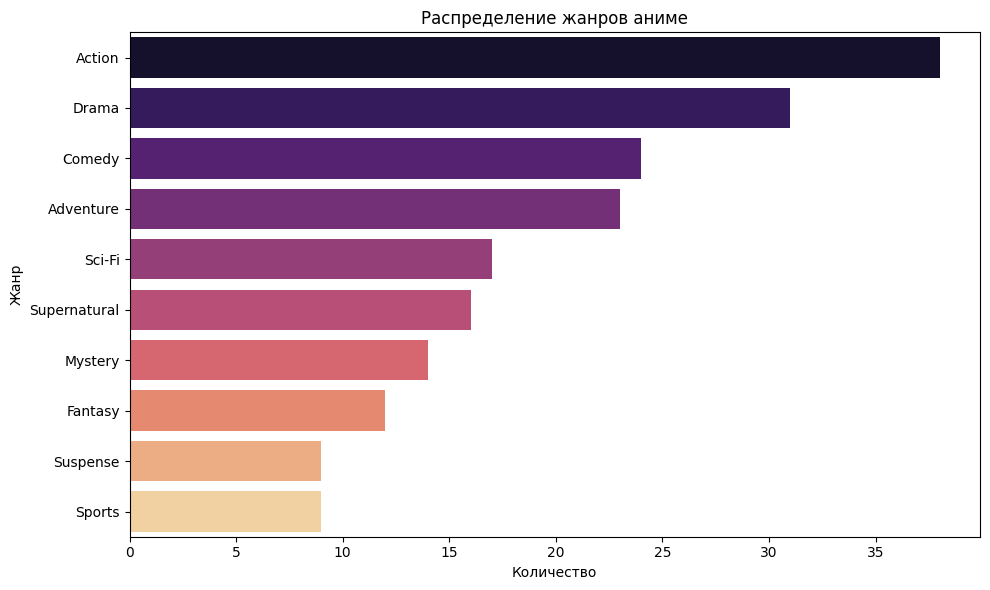

In [89]:
df_genres = df['genres'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
top_genres = df_genres.value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_genres.values, y=top_genres.index, palette='magma')
plt.title('Распределение жанров аниме')
plt.xlabel('Количество')
plt.ylabel('Жанр')
plt.tight_layout()
plt.savefig('top_genres.png', format='PNG', dpi=300)
plt.show()

Сразу в глаза бросается, что Action, Drama, Comedy и Adventure больше всего встречаются среди самыз популярных аниме

### Какие студии чаще всего выпускали аниме

Здесь мы подсчитаем, сколько аниме выпустила каждая студия, и визуализируем топ-10 студий

<ipython-input-102-310359d85841>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=studio_counts.values, y=studio_counts.index, palette='coolwarm')


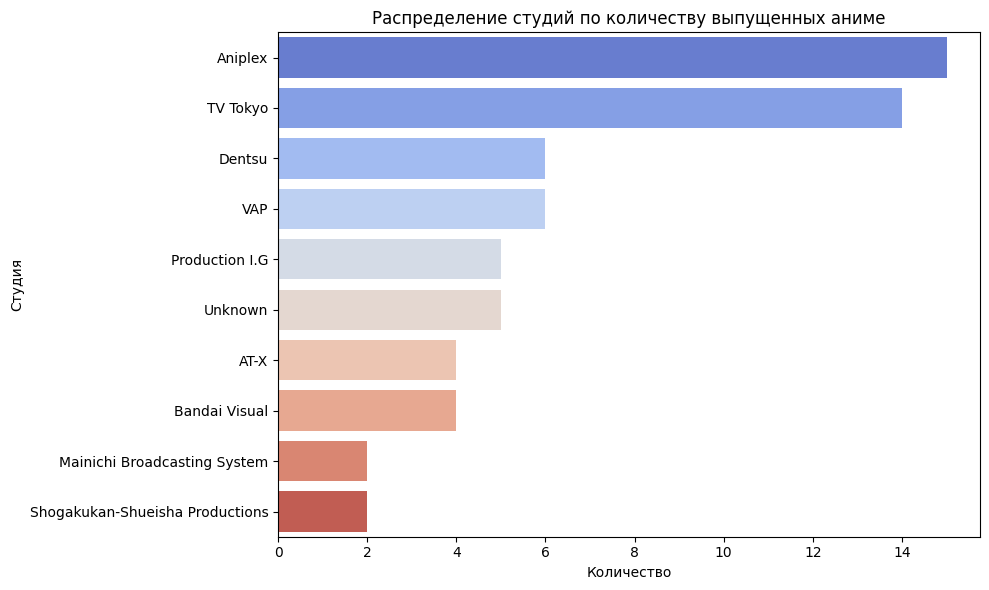

In [102]:
studio_counts = df['studio'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=studio_counts.values, y=studio_counts.index, palette='coolwarm')
plt.title('Распределение студий по количеству выпущенных аниме')
plt.xlabel('Количество')
plt.ylabel('Студия')
plt.tight_layout()
plt.savefig('top_studios.png', format='PNG', dpi=300)
plt.show()

Заметно, что студии Aniplex и TV Tokyo занимают лидирующие позиции. Это и не удивительно, так как эти студии имеют множество проектов. Aniplex —  студия, известная своими популярными проектами, такими как "Demon Slayer" и "Fate". А TV Tokyo — это одна из ведущих японских телевизионных компаний, часто являющаяся частью или партнёром для множества аниме

### Года с наибольшим колчиеством успешных проектов

Теперь проанализируем, в какие года было выпущено больше всего аниме, которые занимают лидирующие позиции

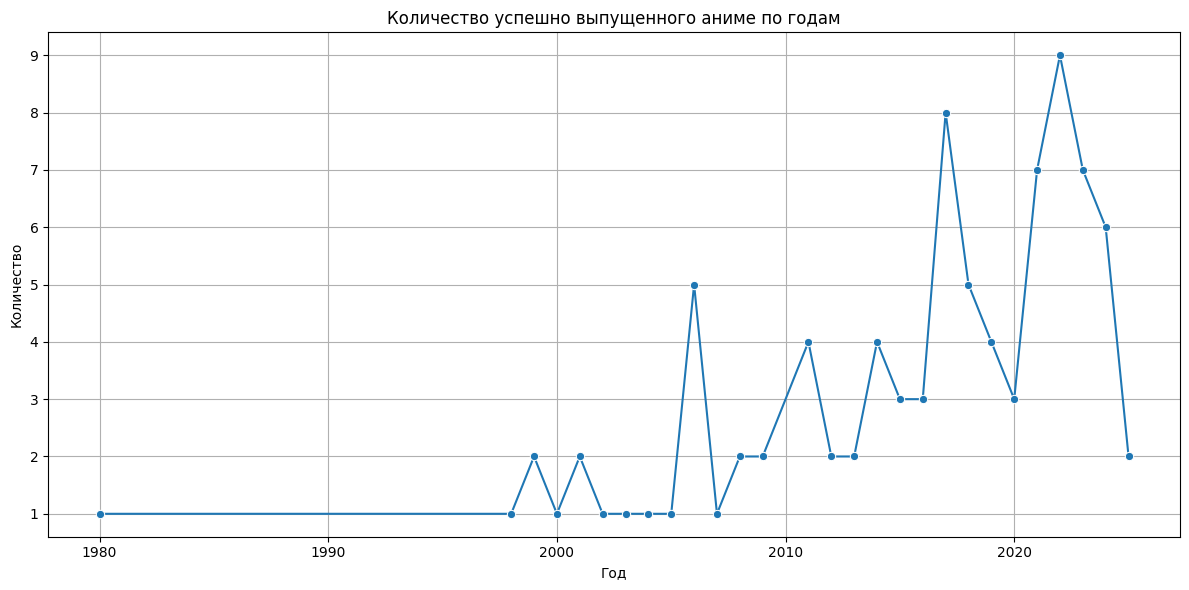

In [104]:
year_counts = df['year'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
sns.lineplot(x=year_counts.index, y=year_counts.values, marker='o')
plt.title('Количество успешно выпущенного аниме по годам')
plt.xlabel('Год')
plt.ylabel('Количество')
plt.grid(True)
plt.tight_layout()
plt.savefig('years.png', format='PNG', dpi=300)
plt.show()

По графику видно, что в 90е и 00е было мало успешных проектов, а вот с 2006 начинается прирост, самый пик приходится на 2017-2024 года. Тут прям заметен рост числа успешных проектов, особенно в 2022 году

### Топ-3 жанра для каждой студии

Посмотрим на распределение жанров по студиям. Были выбраны 10 самых популярных жанров и 5 студий, выпустивших наибольшее количество аниме.

Если кратко пройтись по коду: жанры были разделены с помощью метода str.split(', ') и преобразованы в Series. Далее они были сопоставлены со студиями, после чего выбраны топ-10 жанров и топ-5 студий. Сгруппированы данные по жанрам и студиям, посчитано количество аниме

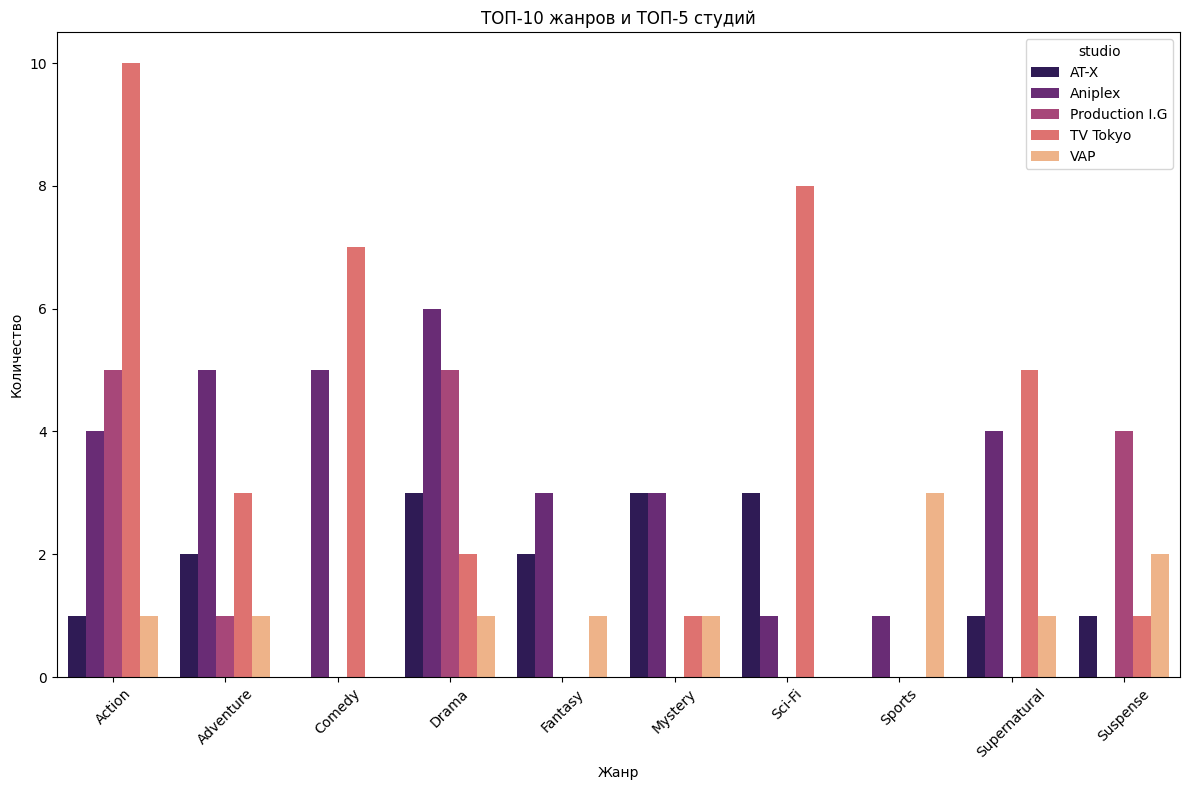

In [105]:
genres = df['genres'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)
studio_genre_df = df[['studio']].join(genre_series.rename('genre'))

top_10_genres = studio_genre_df['genre'].value_counts().head(10).index
filtered = studio_genre_df[studio_genre_df['genre'].isin(top_10_genres)]

top_5_studios = filtered['studio'].value_counts().head(5).index
filtered = filtered[filtered['studio'].isin(top_5_studios)]

grouped = filtered.groupby(['genre', 'studio']).size().reset_index(name='count')

plt.figure(figsize=(12, 8))
sns.barplot(x='genre', y='count', hue='studio', data=grouped, palette='magma')
plt.title('ТОП-10 жанров и ТОП-5 студий')
plt.xlabel('Жанр')
plt.ylabel('Количество')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('top_genres_and_studios.png', format='PNG', dpi=300)
plt.show()

Получился неплохой график с наглядым распределением. Что сразу бросается в глаза:
- Всего 3 жанра экранизируются сразу всеми популярными студиями, это Action, Adventure, Drama
- Comedy и Sport жанры самые менее востребованные
- ВИдно, что студия TV Tokyo сняла в жанрах Action, Sci-Fi, Comedy и Supernatural самое большое число успешных проектов (о чем говорят сильрные выбросы на графике)

### Аниме с самым низким рейтингом

Отдельный раздел посвятим аниме с самым низким рейтингом. Посомтрим, в какие года оно выпускалось, какими студиями и в каких жанрах

<ipython-input-99-89e262e3160f>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=genres, order=genres.value_counts().index, palette='Reds_r')


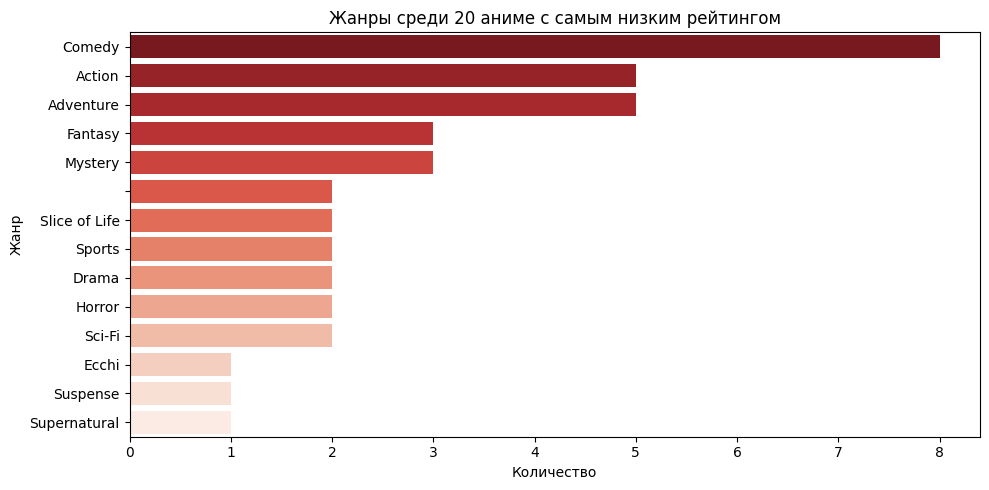

In [99]:
worst_anime = df.nsmallest(20, 'score')

genres = worst_anime['genres'].str.split(', ', expand=True).stack().reset_index(level=1, drop=True)

plt.figure(figsize=(10, 5))
sns.countplot(y=genres, order=genres.value_counts().index, palette='Reds_r')
plt.title('Жанры среди 20 аниме с самым низким рейтингом')
plt.xlabel('Количество')
plt.ylabel('Жанр')
plt.tight_layout()
plt.savefig('worst_anime_genres.png', format='PNG', dpi=300)
plt.show()

<ipython-input-98-8616dc35dd31>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=worst_anime['studio'], order=worst_anime['studio'].value_counts().index, palette='Oranges')


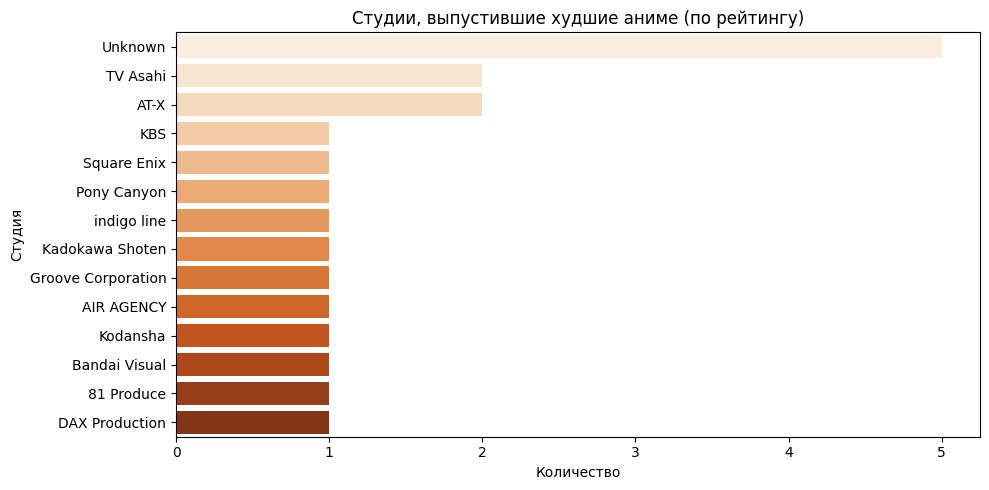

In [98]:
plt.figure(figsize=(10, 5))
sns.countplot(y=worst_anime['studio'], order=worst_anime['studio'].value_counts().index, palette='Oranges')
plt.title('Студии, выпустившие худшие аниме (по рейтингу)')
plt.xlabel('Количество')
plt.ylabel('Студия')
plt.tight_layout()
plt.savefig('worst_anime_studios.png', format='PNG', dpi=300)
plt.show()

<ipython-input-100-86242991e4f1>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=worst_anime['year'], order=worst_anime['year'].value_counts().index, palette='Purples')


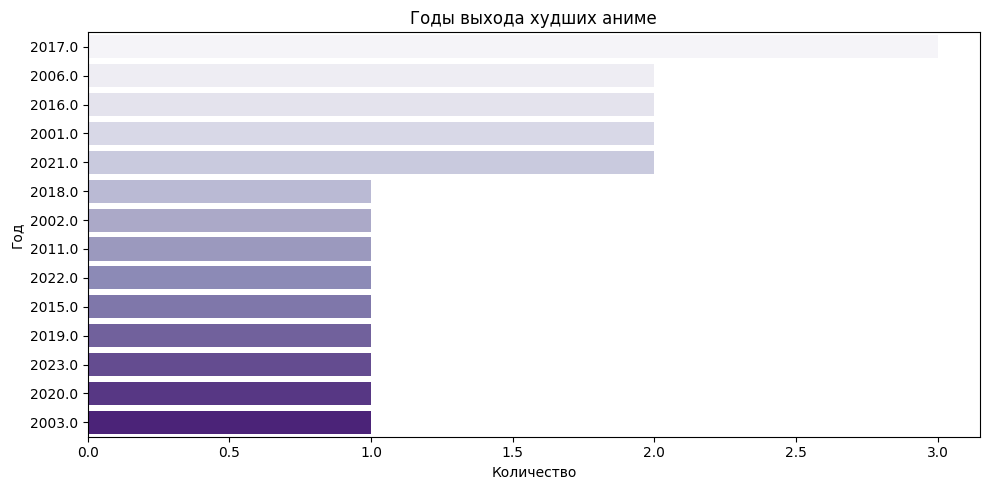

In [100]:
plt.figure(figsize=(10, 5))
sns.countplot(y=worst_anime['year'], order=worst_anime['year'].value_counts().index, palette='Purples')
plt.title('Годы выхода худших аниме')
plt.xlabel('Количество')
plt.ylabel('Год')
plt.tight_layout()
plt.savefig('worst_anime_years.png', format='PNG', dpi=300)
plt.show()

Так ак выборка была небольшая, всего 20 аниме с рейтингом около 5, результат получился не самый точный с точки зрения анализа, однако сделаем выводы на основе графиков:
- В результате Comedy жанр сильно лидирует среди аниме с низким рейтингом. Это интересное наблюдение, так как он лидирует и среди самых популярных. Таким обращзом, направшивается вывод, что комедийный жанр в принципе один из самых популярных среди аниме
- Изначально пустые значения в столбце "studio" были заменены, это и отпразилось на графике. Можно увидеть, что "ноунеймовские" аниме чаще всего получзуются низким спросом :)
- График распределния годов оказался самым простым и не инфомарционно емким. Небольшйо отрыв у 2017 года (3 значения), а оставшиеся года забрали себе либо 2, либо 1 значение. Конкреного вывода сделать нельяза, выборка и правда маленькая, но на основе графика - 2017 год был не только резким скачком хорошего аниме, но и скачком для невостребованного аниме

## Выводы

Основные выводы из глубокого анализа:

- Наиболее популярные жанры среди успешных аниме — это Action, Drama, Comedy и Adventure. Эти жанры наиболее часто встречаются в лучших проектах.
Жанр Comedy, несмотря на свою высокую распространённость в общем списке, одновременно является лидером среди низкорейтинговых аниме.

- Студии Aniplex, TV Tokyo, Madhouse, Bones и Toei Animation оказались наиболее продуктивными в рамках топ-100. Это крупные и признанные компании, которые снимают лучшее аниме по мнению зрителей. TV Tokyo особенно выделяется своим вкладом в жанры Action, Comedy, Supernatural и Sci-Fi.
- Также студии имеют свою жанровую специализацию (например, Bones часто работает с жанрами Sci-Fi и Supernatural). И только три жанра (Action, Drama, Adventure) встречаются у всех лидирующих студий.

- Бум популярности аниме начинается с 2010-х годов, с резким приростом количества высокорейтинговых проектов с 2016 по 2022 годы. Особенно заметен пик в 2022 году. Причины этому: рост интереса к аниме за пределами Японии, активное развитие стриминговых платформ (Netflix, Crunchyroll), улучшение технологий производства.

- Интересным результатом исследования стал тот факт, что 2017 год также попал в список как активный и по числу аниме с низким рейтингом

- В списке из 20 аниме с наименьшим рейтингом наиболее частый жанр — Comedy, что подтверждает его неоднозначность. Студии, снимавшие эти проекты, часто неизвестны. Года выпуска не концентрируются в одном периоде, но 2017 год оказался наиболее представленным среди неуспешных проектов.

## Обсуждение


Проведённый анализ данных о топ-100 аниме и 20 низкорейтинговых проектах с сайта MyAnimeList позволил получить ряд значимых наблюдений о жанровых предпочтениях, активности студий, временной динамике и типичных признаках как успешных, так и провальных аниме-сериалов.

Проект включал этапы очистки и подготовки данных, что обеспечило корректность последующего анализа. Были выделены наиболее популярные жанры (Action, Drama, Adventure), определены ведущие студии, такие как Aniplex и TV Tokyo, а также проанализированы временные тренды, показавшие рост интереса к аниме с 2010-х годов.

Дополнительный акцент был сделан на изучении аниме с низким рейтингом, что позволило взглянуть на индустрию с другой стороны.

Успех аниме часто определяется тремя основными факторами: выбор жанра, студия-производитель и год выпуска. Именно проведенный статистический и визуальный анализ предоставил возможность для более глубокого исследования успешности аниме по входным признакам.

Таким образом, данный анализ позволил не только структурировать ключевые характеристики успешных аниме, но и может стать основой для более глубокой аналитики в сфере аниме, а также для построения рекомендаций по созданию контента, ориентированного на широкую аудиторию